# HW7: SNE, t-SNE
@author: BAIM Mohamed Jalal, 313551810

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import trange
import seaborn as sns

In [2]:
import imageio

def create_gif(folder_name, output_filename='animation.gif', duration=0.3):
    """
    Creates a GIF animation from all .png frames inside 'folder_name'.

    Parameters
    ----------
    folder_name : str
        The directory containing frames (PNG images).
    output_filename : str, optional
        The output GIF filename. Default 'animation.gif'.
    duration : float, optional
        Time (in seconds) between frames. Adjust for desired speed.
    """
    # Retrieve all .png files in sorted order
    frames = sorted(
        [
            f for f in os.listdir(folder_name) 
            if f.endswith('.png') and f.split('.')[0].isdigit()
        ],
        key=lambda x: int(x.split('.')[0])  # sort by integer prefix
    )

    images = []
    for frame_name in frames:
        frame_path = os.path.join(folder_name, frame_name)
        images.append(imageio.v2.imread(frame_path))

    # Save as GIF
    output_path = os.path.join(folder_name, output_filename)
    imageio.mimsave(output_path, images, duration=duration)
    print(f"GIF saved to {output_path}")


In [3]:
def pairwise_distances(X):
    """
    Compute the NxN matrix of squared Euclidean distances for an NxD array X.
    We are replacing 'scipy.spatial.distance.cdist(X, X, "sqeuclidean")'.
    """
    sum_X = np.sum(np.square(X), axis=1, keepdims=True)  # shape (N, 1)
    # D[i,j] = (X[i] - X[j])^2
    #        = X[i]^2 + X[j]^2 - 2 * X[i]*X[j]
    # We'll store it in NxN shape.
    D = sum_X + sum_X.T - 2.0 * np.dot(X, X.T)
    return D

def plot_2D_scatter(Y, labels, iteration, method, perplexity, interval=None):
    """
    Plot the 2D embedding (Y) colored by labels. Save the figure.
    """
    plt.clf()
    scatter = plt.scatter(Y[:, 0], Y[:, 1], c=labels, s=20, cmap='tab10')
    plt.legend(*scatter.legend_elements(), loc='lower left', title='Digit')
    plt.title(f"{method}, perplexity={perplexity}, iteration={iteration}")
    plt.tight_layout()

    folder_name = f"{method}_{perplexity}"
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

    # If interval is provided, you can group images in frames
    if interval:
        filename = os.path.join(folder_name, f"{iteration // interval}.png")
    else:
        filename = os.path.join(folder_name, f"{iteration}.png")

    plt.savefig(filename)
    plt.close()

def plot_similarity_matrices(P, Q, method, perplexity):
    """
    Visualize the similarity matrices in high-dimensional (P) and low-dimensional (Q).
    """
    folder_name = f"{method}_{perplexity}"
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

    pal = sns.light_palette('blue', as_cmap=True)

    # High-D Similarity
    plt.clf()
    plt.title("High-D Similarities (P)")
    plt.imshow(P, cmap=pal, aspect='auto')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(folder_name, "High-D.png"))
    plt.close()

    # Low-D Similarity
    plt.clf()
    plt.title("Low-D Similarities (Q)")
    plt.imshow(Q, cmap=pal, aspect='auto')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(folder_name, "Low-D.png"))
    plt.close()

In [4]:
def pca(X, no_dims=50):
    """
    Preprocess the data using PCA to reduce to 'no_dims' dimensions.
    """
    print("Preprocessing the data using PCA...")
    n, d = X.shape
    # Center the data
    X_centered = X - np.mean(X, axis=0, keepdims=True)
    
    # Compute the covariance matrix: X^T X (or the correlation matrix for data
    # with zero mean). Then compute eigen-decomposition.
    # (We do a trick to avoid forming NxN matrix if we want to.)
    cov_mat = np.dot(X_centered.T, X_centered)
    
    eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
    # Sort eigenvalues
    idx = np.argsort(eigen_vals)[::-1]
    eigen_vecs = eigen_vecs[:, idx]
    
    # Take the first 'no_dims' eigenvectors
    eigen_vecs_reduced = eigen_vecs[:, :no_dims]
    Y = np.dot(X_centered, eigen_vecs_reduced)
    return Y.real

In [5]:
def Hbeta(Di, beta):
    """
    Given a distance array Di for a single point i to all other points,
    and a precision parameter beta (1 / (2*sigma^2)),
    returns the entropy H and the probabilities P for that row.
    """
    # Compute the Gaussian kernel row
    P = np.exp(-Di * beta)
    sumP = np.sum(P)
    # Shannon entropy
    H = np.log(sumP) + beta * np.sum(Di * P) / sumP
    # Normalize to get probabilities
    P = P / sumP
    return H, P


def x2p(X, perplexity=30.0, tol=1e-5):
    """
    Computes the P matrix for all points in the dataset X using binary search
    to match a desired perplexity for each row.
    Returns an NxN matrix P.
    """
    print("Computing pairwise distances...")
    n, d = X.shape

    # Pairwise distances NxN
    D = pairwise_distances(X)  # shape (N, N)

    # Initialize P, betas
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    for i in range(n):
        if i % 500 == 0:
            print(f"Computing P-values for point {i} of {n}...")

        # Exclude self-distance
        Di = np.delete(D[i, :], i)
        
        # Initial guesses
        betamin = -np.inf
        betamax = np.inf
        
        # Compute H and P row for this beta
        H, thisP = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0

        while np.abs(Hdiff) > tol and tries < 50:
            if Hdiff > 0:
                # Need to increase perplexity => reduce beta
                betamin = beta[i].copy()
                if np.isinf(betamax):
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                # Need to decrease perplexity => increase beta
                betamax = beta[i].copy()
                if np.isinf(betamin):
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        
        # Re-insert self-distance = 0
        P[i, np.arange(n) != i] = thisP

    print(f"Mean value of sigma: {np.mean(np.sqrt(1 / beta))}")
    return P

In [8]:
def sne(
    X, 
    labels=None,
    method='tsne',        # 'tsne' or 'ssne' (symmetric SNE)
    no_dims=2,
    initial_dims=50,
    perplexity=30.0,
    max_iter=1000,
    interval=50,
    early_exaggeration=4.0
):
    """
    Perform SNE or t-SNE on dataset X, returning the 2D embedding Y,
    as well as the high-dimensional similarities P and low-dimensional Q.

    Parameters:
    -----------
    X : np.ndarray
        Data matrix of shape (N, D).
    labels : np.ndarray, optional
        Ground truth labels for visualization (e.g. digits).
    method : str
        'tsne' for t-SNE or 'ssne' for symmetric SNE.
    no_dims : int
        Embedding dimensionality (default 2).
    initial_dims : int
        PCA dimensionality reduction (default 50).
    perplexity : float
        Perplexity used for constructing P.
    max_iter : int
        Number of SNE iterations.
    interval : int
        Interval (in iterations) at which we visualize the current embedding.
    early_exaggeration : float
        Factor to multiply P by during early exaggeration.

    Returns:
    --------
    Y : np.ndarray
        The embedding of shape (N, no_dims).
    P : np.ndarray
        High-dimensional similarity matrix of shape (N, N).
    Q : np.ndarray
        Low-dimensional similarity matrix of shape (N, N).
    """

    # 1) PCA step
    X_pca = pca(X, initial_dims)
    n, d = X_pca.shape

    # 2) Initialize Y randomly
    Y = np.random.randn(n, no_dims)

    # 3) Compute P
    P = x2p(X_pca, perplexity=perplexity, tol=1e-5)
    P = P + P.T
    P /= np.sum(P)
    P *= early_exaggeration  # early exaggeration
    P = np.maximum(P, 1e-12)

    # Some t-SNE hyperparams
    momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01

    # Bookkeeping
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    for itr in range(max_iter):
        # 4) Compute pairwise affinities Q in the low-dimensional space
        #    For t-SNE:
        #       num_ij = 1 / (1 + ||y_i - y_j||^2)
        #    For symmetric SNE:
        #       num_ij = exp(-||y_i - y_j||^2)

        distY = pairwise_distances(Y)
        if method == 'tsne':
            num = 1.0 / (1.0 + distY)
        else:
            # symmetric SNE
            num = np.exp(-distY)

        # zero out self elements
        np.fill_diagonal(num, 0.0)

        # Q = num / sum(num)
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # 5) Compute the gradient
        PQ = P - Q  # NxN
        # for i in range(n):
        #     # row_i => shape (N,)
        #     # For t-SNE, we also incorporate the (1 + distY) factor in the gradient
        #     dY[i, :] = np.sum(
        #         np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y),
        #         axis=0
        #     )
        for i in range(n):
            if method == 'tsne':
                dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), axis=0)
            else:
                dY[i, :] = np.sum(np.tile(PQ[:, i], (no_dims, 1)).T * (Y[i, :] - Y), axis=0)

        # 6) Update Y
        if itr < 20:
            m = momentum
        else:
            m = final_momentum

        # Update gains
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + \
                (gains * 0.8) * ((dY > 0) == (iY > 0))
        gains[gains < min_gain] = min_gain

        iY = m * iY - eta * (gains * dY)
        Y += iY
        # Center Y to remove global mean
        Y -= np.mean(Y, axis=0, keepdims=True)

        # 7) Visualization
        if (itr % interval == 0) and (labels is not None):
            plot_2D_scatter(Y, labels, iteration=itr, method=method, perplexity=perplexity, interval=interval)

        # 8) Track the cost
        if (itr + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print(f"Iteration {itr+1}: error is {C:.4f}")

        # 9) End early exaggeration after some iterations
        if itr == 100:
            P /= early_exaggeration

    return Y, P, Q

In [9]:
X = np.loadtxt("/kaggle/input/tsne-dataset/mnist2500_X.txt")
labels = np.loadtxt("/kaggle/input/tsne-dataset/mnist2500_labels.txt")

# Let's do t-SNE on it
Y_tsne, P_tsne, Q_tsne = sne(
    X,
    labels=labels,
    method='tsne',
    no_dims=2,
    initial_dims=50,
    perplexity=30.0,
    max_iter=1000,
    interval=50,
    early_exaggeration=4.0
)
plot_2D_scatter(Y_tsne, labels, iteration='final', method='tsne', perplexity=30)

plot_similarity_matrices(P_tsne, Q_tsne, method='tsne', perplexity=30)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573318715862812
Iteration 10: error is 22.3487
Iteration 20: error is 19.8188
Iteration 30: error is 16.8307
Iteration 40: error is 15.9900
Iteration 50: error is 15.7799
Iteration 60: error is 15.6845
Iteration 70: error is 15.6106
Iteration 80: error is 15.5579
Iteration 90: error is 15.5285
Iteration 100: error is 15.5030
Iteration 110: error is 2.1968
Iteration 120: error is 1.9121
Iteration 130: error is 1.7192
Iteration 140: error is 1.5858
Iteration 150: error is 1.4886
Iteration 160: error is 1.4151
Iteration 170: error is 1.3580
Iteration 180: error is 1.3122
Iteration 190: error is 1.2746
Iteration 200: error is 1.2432
Iteration 210: error is 1.2167
Iteration 220: error

In [10]:
Y_ssne, P_ssne, Q_ssne = sne(
    X,
    labels=labels,
    method='ssne',
    no_dims=2,
    initial_dims=50,
    perplexity=30.0,
    max_iter=1000,
    interval=50,
    early_exaggeration=4.0
)
plot_2D_scatter(Y_ssne, labels, iteration='final', method='ssne', perplexity=30)
plot_similarity_matrices(P_ssne, Q_ssne, method='ssne', perplexity=30)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573318715862812
Iteration 10: error is 22.1889
Iteration 20: error is 17.4349
Iteration 30: error is 16.1521
Iteration 40: error is 16.1427
Iteration 50: error is 16.1350
Iteration 60: error is 16.0972
Iteration 70: error is 16.0915
Iteration 80: error is 16.0990
Iteration 90: error is 16.0913
Iteration 100: error is 16.0935
Iteration 110: error is 2.1026
Iteration 120: error is 1.9436
Iteration 130: error is 1.9438
Iteration 140: error is 1.9577
Iteration 150: error is 1.9623
Iteration 160: error is 1.9600
Iteration 170: error is 1.9582
Iteration 180: error is 1.9579
Iteration 190: error is 1.9580
Iteration 200: error is 1.9580
Iteration 210: error is 1.9580
Iteration 220: error

In [12]:
create_gif(folder_name="tsne_30.0", output_filename="tsne_30.gif", duration=0.3)
create_gif(folder_name="ssne_30.0", output_filename="ssne_30.gif", duration=0.3)

GIF saved to tsne_30.0/tsne_30.gif
GIF saved to ssne_30.0/ssne_30.gif


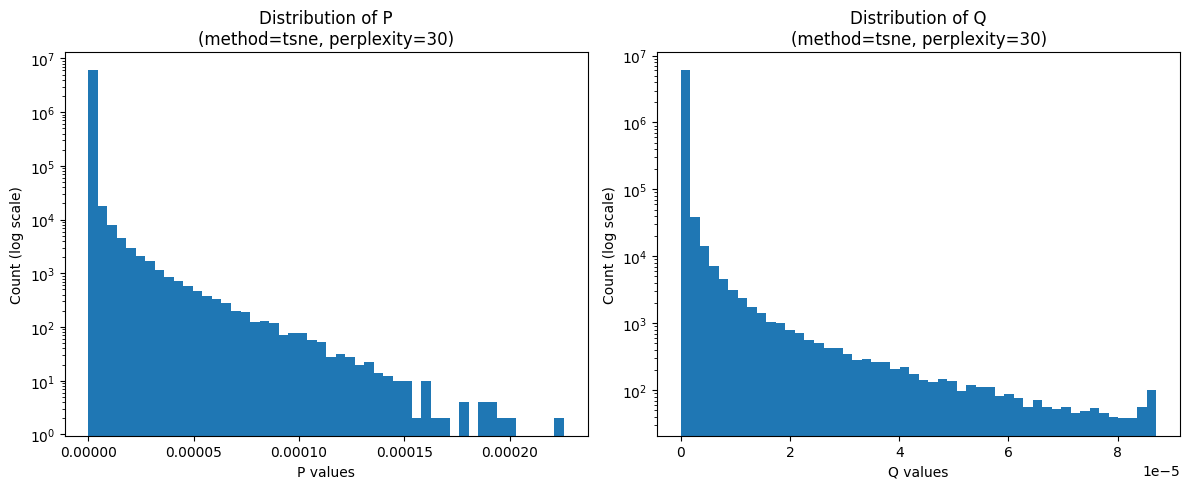

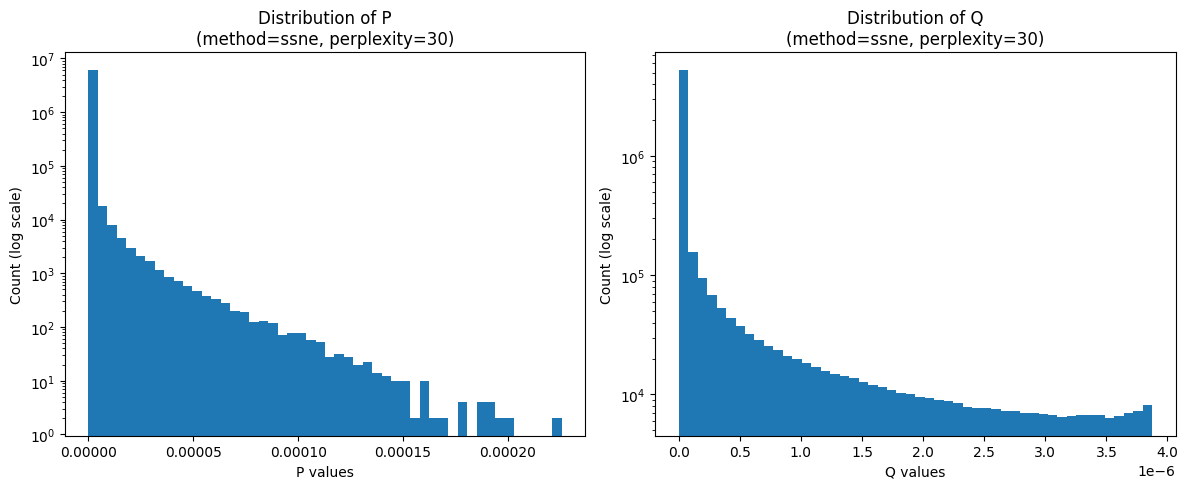

In [13]:
def plot_similarity_distribution(P, Q, method, perplexity, bins=50):
    """
    Plot histograms of P and Q distributions on a log scale.
    """
    folder_name = f"{method}_{perplexity}"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name, exist_ok=True)

    # Flatten P, Q
    P_flat = P.ravel()
    Q_flat = Q.ravel()

    # Avoid zeros that can ruin the log scale
    P_flat = P_flat[P_flat > 0]
    Q_flat = Q_flat[Q_flat > 0]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(P_flat, bins=bins, log=True)
    plt.title(f"Distribution of P\n(method={method}, perplexity={perplexity})")
    plt.xlabel("P values")
    plt.ylabel("Count (log scale)")

    plt.subplot(1, 2, 2)
    plt.hist(Q_flat, bins=bins, log=True)
    plt.title(f"Distribution of Q\n(method={method}, perplexity={perplexity})")
    plt.xlabel("Q values")
    plt.ylabel("Count (log scale)")

    plt.tight_layout()
    plt.savefig(os.path.join(folder_name, "distribution_PQ.png"))
    plt.show()
    plt.close()

plot_similarity_distribution(P_tsne, Q_tsne, method='tsne', perplexity=30)
plot_similarity_distribution(P_ssne, Q_ssne, method='ssne', perplexity=30)


--- t-SNE with perplexity=5 ---
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 1.7600567616425047
Iteration 10: error is 28.2416
Iteration 20: error is 25.8092
Iteration 30: error is 22.2574
Iteration 40: error is 20.4551
Iteration 50: error is 19.5980
Iteration 60: error is 19.1259
Iteration 70: error is 18.7377
Iteration 80: error is 18.4169
Iteration 90: error is 18.1604
Iteration 100: error is 17.9268
Iteration 110: error is 2.8906
Iteration 120: error is 2.7068
Iteration 130: error is 2.5320
Iteration 140: error is 2.3665
Iteration 150: error is 2.2181
Iteration 160: error is 2.0906
Iteration 170: error is 1.9855
Iteration 180: error is 1.9027
Iteration 190: error is 1.8347
Iteration 200: error is 1.7753
Iteration 210: er

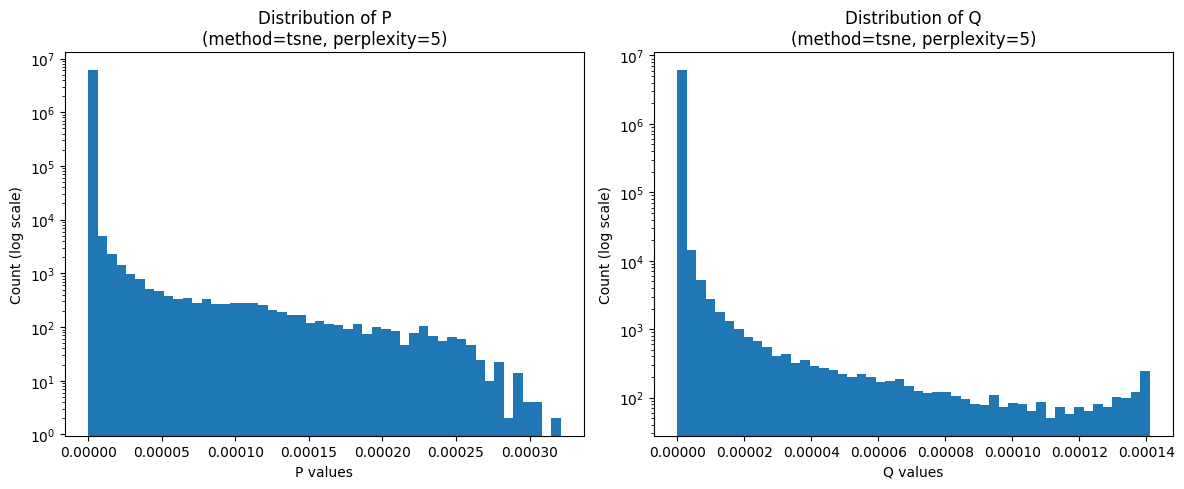

GIF saved to tsne_5/tsne_5.gif

--- s-SNE with perplexity=5 ---
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 1.7600567616425047
Iteration 10: error is 27.8060
Iteration 20: error is 23.0007
Iteration 30: error is 19.6929
Iteration 40: error is 19.3310
Iteration 50: error is 19.2624
Iteration 60: error is 19.0978
Iteration 70: error is 18.8270
Iteration 80: error is 18.6329
Iteration 90: error is 18.6451
Iteration 100: error is 18.6281
Iteration 110: error is 2.8610
Iteration 120: error is 2.5041
Iteration 130: error is 2.4233
Iteration 140: error is 2.4116
Iteration 150: error is 2.4099
Iteration 160: error is 2.4098
Iteration 170: error is 2.4079
Iteration 180: error is 2.4031
Iteration 190: error is 2.3999
Iteration 200: er

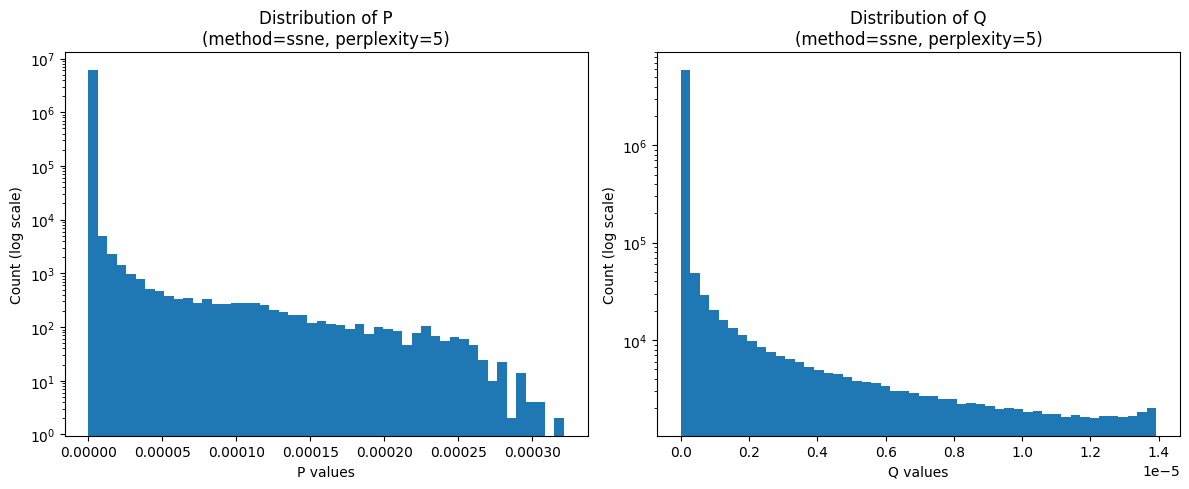

GIF saved to ssne_5/ssne_5.gif

--- t-SNE with perplexity=10 ---
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.077835950680082
Iteration 10: error is 25.9666
Iteration 20: error is 23.3023
Iteration 30: error is 19.8711
Iteration 40: error is 18.3564
Iteration 50: error is 17.8070
Iteration 60: error is 17.4975
Iteration 70: error is 17.2672
Iteration 80: error is 17.1068
Iteration 90: error is 16.9693
Iteration 100: error is 16.8573
Iteration 110: error is 2.5810
Iteration 120: error is 2.3878
Iteration 130: error is 2.2145
Iteration 140: error is 2.0628
Iteration 150: error is 1.9354
Iteration 160: error is 1.8299
Iteration 170: error is 1.7424
Iteration 180: error is 1.6695
Iteration 190: error is 1.6090
Iteration 200: er

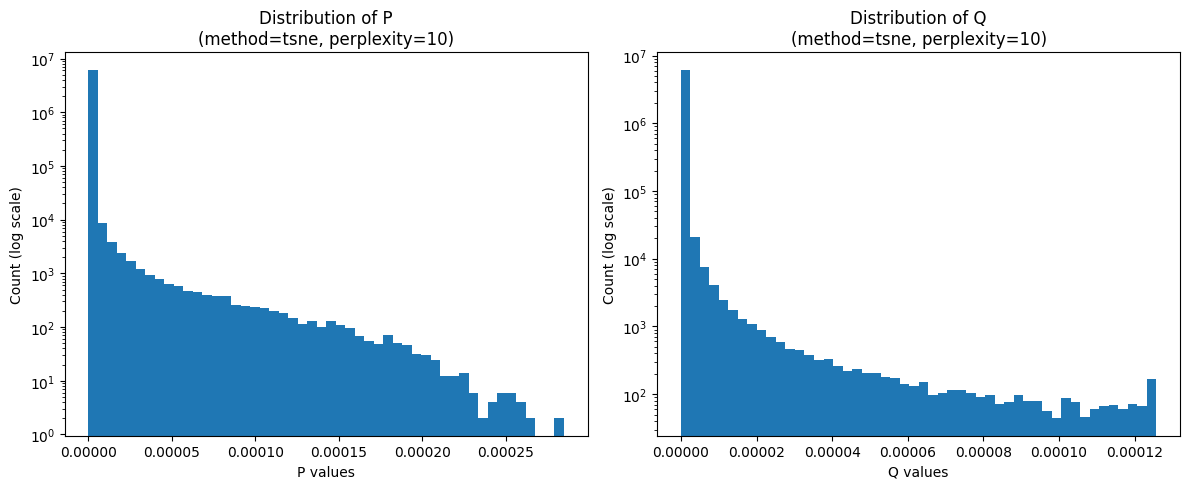

GIF saved to tsne_10/tsne_10.gif

--- s-SNE with perplexity=10 ---
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.077835950680082
Iteration 10: error is 25.7275
Iteration 20: error is 20.7617
Iteration 30: error is 18.2968
Iteration 40: error is 18.3665
Iteration 50: error is 17.9566
Iteration 60: error is 17.7099
Iteration 70: error is 17.7135
Iteration 80: error is 17.6967
Iteration 90: error is 17.7091
Iteration 100: error is 17.6920
Iteration 110: error is 2.5339
Iteration 120: error is 2.2868
Iteration 130: error is 2.2702
Iteration 140: error is 2.2773
Iteration 150: error is 2.2883
Iteration 160: error is 2.2935
Iteration 170: error is 2.2935
Iteration 180: error is 2.2926
Iteration 190: error is 2.2919
Iteration 200: 

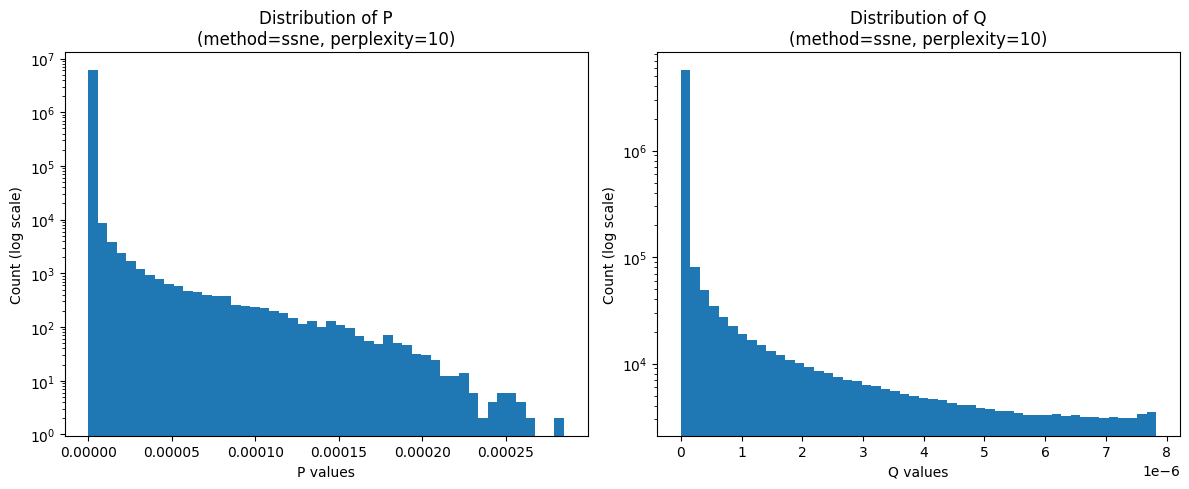

GIF saved to ssne_10/ssne_10.gif

--- t-SNE with perplexity=30 ---
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573318715862812
Iteration 10: error is 22.0024
Iteration 20: error is 19.3930
Iteration 30: error is 16.7865
Iteration 40: error is 15.9477
Iteration 50: error is 15.7356
Iteration 60: error is 15.6369
Iteration 70: error is 15.5937
Iteration 80: error is 15.5397
Iteration 90: error is 15.5019
Iteration 100: error is 15.4803
Iteration 110: error is 2.1682
Iteration 120: error is 1.8867
Iteration 130: error is 1.7007
Iteration 140: error is 1.5729
Iteration 150: error is 1.4794
Iteration 160: error is 1.4082
Iteration 170: error is 1.3523
Iteration 180: error is 1.3077
Iteration 190: error is 1.2710
Iteration 200: 

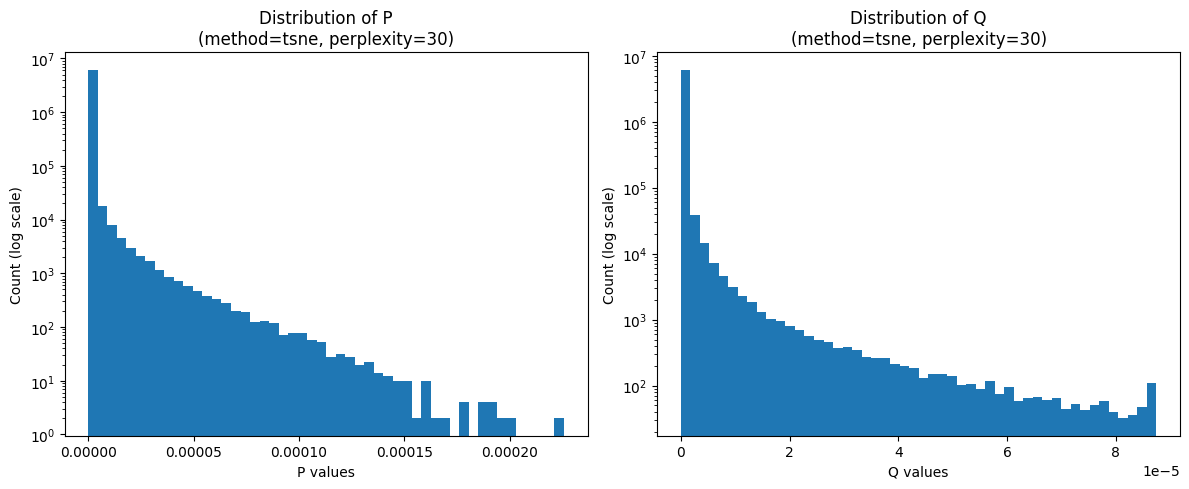

GIF saved to tsne_30/tsne_30.gif

--- s-SNE with perplexity=30 ---
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573318715862812
Iteration 10: error is 22.2898
Iteration 20: error is 18.2738
Iteration 30: error is 16.8805
Iteration 40: error is 17.0204
Iteration 50: error is 16.8230
Iteration 60: error is 16.8667
Iteration 70: error is 16.6598
Iteration 80: error is 16.0859
Iteration 90: error is 16.2174
Iteration 100: error is 16.2002
Iteration 110: error is 2.0985
Iteration 120: error is 1.9619
Iteration 130: error is 1.9629
Iteration 140: error is 1.9762
Iteration 150: error is 1.9804
Iteration 160: error is 1.9778
Iteration 170: error is 1.9761
Iteration 180: error is 1.9763
Iteration 190: error is 1.9768
Iteration 200: 

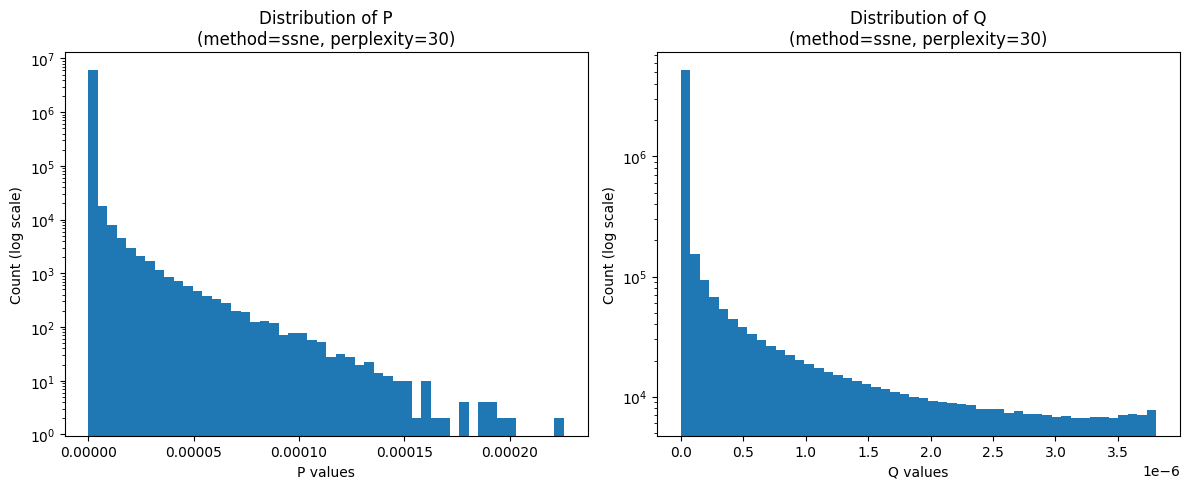

GIF saved to ssne_30/ssne_30.gif

--- t-SNE with perplexity=50 ---
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.8228168868993238
Iteration 10: error is 20.1849
Iteration 20: error is 18.1313
Iteration 30: error is 15.6939
Iteration 40: error is 14.9450
Iteration 50: error is 14.9076
Iteration 60: error is 14.9624
Iteration 70: error is 15.0132
Iteration 80: error is 15.0444
Iteration 90: error is 15.0580
Iteration 100: error is 15.0643
Iteration 110: error is 2.0450
Iteration 120: error is 1.6916
Iteration 130: error is 1.4897
Iteration 140: error is 1.3673
Iteration 150: error is 1.2853
Iteration 160: error is 1.2261
Iteration 170: error is 1.1809
Iteration 180: error is 1.1454
Iteration 190: error is 1.1167
Iteration 200:

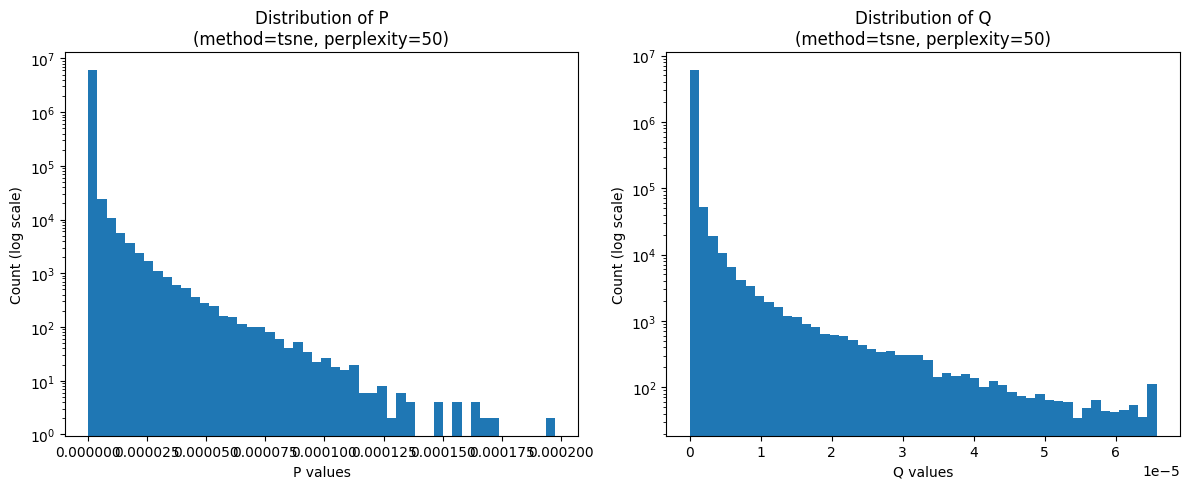

GIF saved to tsne_50/tsne_50.gif

--- s-SNE with perplexity=50 ---
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.8228168868993238
Iteration 10: error is 20.1019
Iteration 20: error is 15.8232
Iteration 30: error is 15.2436
Iteration 40: error is 15.4010
Iteration 50: error is 15.3167
Iteration 60: error is 15.3462
Iteration 70: error is 15.3423
Iteration 80: error is 15.3416
Iteration 90: error is 15.3418
Iteration 100: error is 15.3415
Iteration 110: error is 1.8737
Iteration 120: error is 1.7832
Iteration 130: error is 1.7870
Iteration 140: error is 1.7978
Iteration 150: error is 1.7956
Iteration 160: error is 1.7925
Iteration 170: error is 1.7918
Iteration 180: error is 1.7917
Iteration 190: error is 1.7912
Iteration 200:

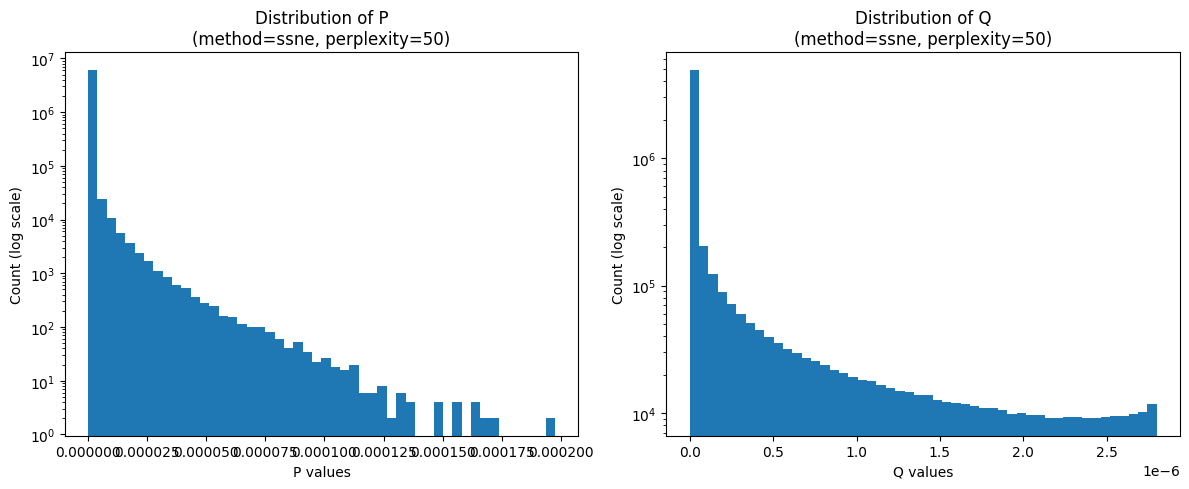

GIF saved to ssne_50/ssne_50.gif


In [14]:
# Example of trying multiple perplexities
perplexities = [5, 10, 30, 50]

for perp in perplexities:
    print(f"\n--- t-SNE with perplexity={perp} ---")
    Y_tsne, P_tsne, Q_tsne = sne(
        X,
        labels=labels,
        method='tsne',
        no_dims=2,
        initial_dims=50,
        perplexity=perp,
        max_iter=1000,
        interval=50,
        early_exaggeration=4.0
    )
    plot_2D_scatter(Y_tsne, labels, iteration='final', method='tsne', perplexity=perp)
    plot_similarity_matrices(P_tsne, Q_tsne, method='tsne', perplexity=perp)
    plot_similarity_distribution(P_tsne, Q_tsne, method='tsne', perplexity=perp)
    create_gif(folder_name=f"tsne_{perp}", output_filename=f"tsne_{perp}.gif", duration=0.3)

    print(f"\n--- s-SNE with perplexity={perp} ---")
    Y_ssne, P_ssne, Q_ssne = sne(
        X,
        labels=labels,
        method='ssne',
        no_dims=2,
        initial_dims=50,
        perplexity=perp,
        max_iter=1000,
        interval=50,
        early_exaggeration=4.0
    )
    plot_2D_scatter(Y_ssne, labels, iteration='final', method='ssne', perplexity=perp)
    plot_similarity_matrices(P_ssne, Q_ssne, method='ssne', perplexity=perp)
    plot_similarity_distribution(P_ssne, Q_ssne, method='ssne', perplexity=perp)
    create_gif(folder_name=f"ssne_{perp}", output_filename=f"ssne_{perp}.gif", duration=0.3)